<a href="https://colab.research.google.com/github/HyeSeong-Lee/NLP_XLNet/blob/main/XLNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XL Net
AutoRegressive Language Model과 Autoencoding모델을 결합해 두 모델의 장점을 모두 취하는 모델입니다.

1. AutoRegressive Language Model(이하 AR)

 - 목적: 순차적으로 다음 토큰을 예측하는 것
 - 방식: word vector를 기반으로 순방향 or 역방향 likelihood 계산
 
   word vector가 $x=(x_1,...,x_T)$로 정의될 때, $P(x)$에 대한 식은 아래와 같습니다.
 - 공식(순방향): $∏^{T}_{t=1}p(x_T|X_{<t})$ 
 - 공식(역역방향): $∏^{T}_{t=1}p(x_T|X_{>t})$
 
   이에 maximum likelihood방식을 적용하는데, 일반적인 notation과 같이, likelihood에 log를 취해 최대화하는 방향으로 진행합니다. 위의 식을 기반으로 도출한 식은 아래와 같습니다.

   $max_\theta(log(p_Θ(x)))=Σ_{t=1}^{T}log(p_\theta(x_t|X_{<t}))=Σ_{t=1}^{T}log\frac{exp(h_Θ(X_{1:t-1})^Te(x_t))}{Σ_{x^{\prime}}exp(X_{x_1:t-1})^Te(x^\prime)}$

 where, $h_Θ(X_{1:t-1})$ is context representation, $e(x)$ is embedding of $x$.

  수식은 어렵지만, 다음의 예시로 쉽게 이해할 수 있습니다..

  "I am a student" => [I, am, a, student]가 있고, $x_t=$"student"라면, 순방향일 때 "I", "am", "a"를 가지고 뒤에 어떤 단어가 올 것인지 예측하는 것입니다. 당연하게도, 답은 "student"가 나오는 것이 바람직하고, 최대한 student로 예측하도록 해야 할 것입니다.

  역방향의 경우, $x_t=$"I"라고 할 경우, "am", "a", "student"를 가지고, $x_t$가 무엇이 될지 맞추는 것입니다.

  단점: 정방향, 역방향 중 한 방향으로만 인코딩할 수 있어, 양방향 인코딩이 필요한 경우 한계가 생깁니다다.

2. AutoEncoding(이하 AE)
  - 요약: 자기 자신을 예측하는 것을 목표로 합니다.
  - noise가 섞여 망가진 데이터를 입력받아, 원래 데이터를 복원하는 데에도 사용됨
  - BERT모델의 경우 문장에서 특정 단어를 masking하고 이를 원래 단어로 예측하는 방식의 학습이 이루어집니다
  - 수식: $max_Θ(log(p_Θ(x̄|x̂)))=Σ_{t=1}^Tm_tlog(p_Θ(x_t|x̂))$
  - "he is a great professor"라는 문장이 있을 때, great를 masking을 하고, 이를 복원하는 과정을 수행하는데, "he is a"와 "professor"를 가지고 "great"를 예측하는 작업을 수행하는 것입니다.
  - 독립 가정: 모든 토큰(단어)는 서로 독립적임

  장점: 양방향(순방향, 역방향) 학습이 가능(앞 뒤 모두를 고려해 해당 토큰을 예측하기 때문)

  단점: masking된 단어는 pretrain을 진행하는 과정에서만 등장해, finetuning을 진행할 경우 결과가 달라질 수 있습니다. 또한, 독립 가정이 깨지는 순간이 오는데, "Natural language processing is funny"에서, Natural language processing은 실질적으로 한 단어로 간주되어야 하지만(서로 종속적이지만) 각각 독립적인 단어로 간주되기 때문입니다.

3. XLNet은 어떻게 두 모델을 결합하는가?
 - 앞서 언급했듯, AR에서는 특정 방향에 대해 likelihood를 계산합니다. 하지만, XLNet에서는 가능한 모든 순서의 permutation에 대해 $log(likelihood)$를 구하고 이를 최대화합니다. (permutation은 추후 설명)
 -  또한, BERT의 경우 입력 단어에 masking을 넣고, 이를 통해 원래 문장을 복구하는 방식이었습니다. 하지만, XLNet에선 입력에 Masking을 넣지 않아 finetuning을 하더라도 결과에 차이가 생기지 않습니다.

Step 1: permutation language model 기본 method

$max_Θ(E_{z\sim Z_T}$$(Σlog(p_Θ(x_{z_t}|X_{Z<t}))))$ for t 1~T

  where $z$ is token, $z_t$ is $t'$th token, $Z_T$ is token vector.
  permutation이란, 다음 설명과 같다. 토큰 벡터가 <$x_1$,$x_2$, $x_3$,>로 정의된다고 할 때 순서를 <$x_1, x_2, x_3$>, <$x_1, x_3, x_2$>, <$x_2, x_1, x_3$>, <$x_2, x_3, x_1$>, <$x_3, x_1, x_2$>, <$x_3, x_2, x_1$>의 순서쌍을 가질 수 있는데 이 permutation이라고 한다.

  아래와 같이 모든 순서쌍에 대해 순방향으로 AR을 수행한다.

  즉, $len(tokenVector)!$만큼의 순서쌍이 존재하고, 각 순서쌍에 대해 AR을 수행한다.

  이것에 대한 문제점은, 이 방식만으로는 실제 문장에서의 단어 순서를 고려하지 못한다는 것이다.


Step 2: 순서가 고려되는 이유
논문은 모든 permutation에 대해 모델의 파라미터(Θ)가 공유되면, 위치 정보를 얻을 수 있을 수 있다고 주장합니다.

실제로 입력받은 데이터 원본의 순서를 뒤섞으며 수행하는 것이 아니라, 조건부 확률의 곱으로 분리할 때 잠시 순서를 섞고, 원본은 모델이 각 토큰의 실제 위치를 알 수 있게 보존해둡니다.

하지만, 긴 문장의 경우 모든 순서쌍에 대해 연산을 수행할 수는 없습니다. 코드를 읽어보니, 실제로는 모든 순서쌍 중에서 일부만 sampling해 그것들에 대해서만 연산을 수행합니다.

   image.png
      
    위 사진은 data_utils.py의 579번째 줄에 정의된 함수입니다. 저기서 인자로 perm_size가 들어가는데, sampling할 때 perm_size만큼 shuffle합니다. 이 말의 뜻은, perm_size=2일때 [1,3,5]와 [2,4,6]가 있다면, [2, 1, 4, 3, 6, 5]와 같이 섞이게 됩니다. 해당 작업을 수행하는 코드는 같은 함수 내의 아래에 보이는 부분에 해당합니다.
    
 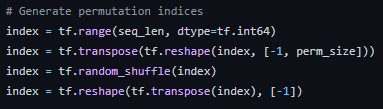

    - 그럼 모든 순서를 고려하지 않아 문제가 생기는 것이 아닐까 하는 의문을 가지게 됩니다. 하지만, 모든 순서에 대해 모델 파라미터가 공유되기 때문에, 데이터가 많이 쌓이다 보면 실질적으로 모든 순서를 공유하는 것으로 간주할 수 있습니다.

4. 문제점
  - "Be as proud of Sogang as Sogang is proud of you"라는 문장의 < Be, as, proud, of, Sogang, as, Sogang, is, proud, of, you>라는 순서쌍과 < Be, as, proud, of, Sogang, as, Sogang, is, proud, you, of >라는 순서쌍을 고려해볼 때, of를 예측하는 데에도, 문장의 마지막에 나오는 you를 예측하는 데에도 < Be, as, proud, of, Sogang, as, Sogang, is, proud>에 대한 정보가 사용됩니다. 즉, 다른 토큰을 예측하는데에 같은 파라미터를 사용한다는 것입니다. 아무리 토큰의 실제 위치를 알도록 보존하고, 파라미터를 모두 공유한다고 해도 단어의 실제 위치와는 상관없이 같은 분포가 예측될 수 있습니다. 이를 수식으로 설명드리겠습니다. AE에 있는 수식 중 최종적으로 도출된 식 $Σ_{t=1}^{T}log\frac{exp(h_Θ(X_{1:t-1})^Te(x_t))}{Σ_{x^{\prime}}exp(X_{x_1:t-1})^Te(x^\prime)}$에서 같은 $h_Θ$를 가지고 다른 토큰을 예측해야하는 문제가 생긴다는 것입니다. 따라서, 논문에서는 실제 위치인 $z_t$를 입력받는 representation "$g_Θ$"를 사용해 식을 다음과 같이 변형합니다.$Σ_{t=1}^{T}log\frac{exp(g_Θ(X_{Z<t},z_t)^Te(x_t))}{Σ_{x^{\prime}}exp(g_\theta(X_{Z<t}, z_t)^Te(x^\prime))}$
  
  Two-Stream self attention
    여기서, 제약조건이 생깁니다. $g_Θ(X_{z<t},z_t)$를 예측할 때 $z_t$의 위치만 사용해야 하고 x_{z_t}의 내용을 활용해선 안됩니다. 정답을 알려주어 너무 쉬운 문제가 될 수 있기 때문입니다. 하지만, 다른 것을 예측하기 위해서(정확히 말하면 t보다 큰 어떤 z에 대해 예측하기 위해)는 $g_Θ$가 x_{z_t}$를 인코딩해야 한다는 것입니다. 이 문제를 해결하기 위해 2개의 hidden representation을 사용하게 됩니다.
    
1. content representation
      
$h_Θ(x_{z<=t})$: 이는 standard 트렌스포머의 hidden state와 같은 역할을 수행하는데, context와 $x_{z_t}$를 같이 인코딩 합니다.

$h_{z_t}^{(m)}$은 m번째 stream layer를 의미하고, 이는 아래와 같이 정의됩니다.

\begin{cases} e(x_i), if\;m=0\\
Attention(Q=h_{z_t}^{(m-1)}, KV=h_{z<=t}^{(m-1)};\theta)\; if\;m>0
\end{cases}

m이 0일때 초기 가중치 $e(x_i)$로 초기화되고, $h_{z=t}^{(m-1)}$을 포함해 스스로에 대한 정보는 포함합니다.

  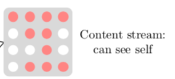


2. query representation
      
$g_Θ(x_{z<t},z_t)$: 이는 $x_{z<t}$와 $z_t$에 대한 문맥 정보를 포함하지만 $x_{z_t}$에 대한 정보는 포함하지 않습니다. 마찬가지로, $g_{z_t}^{(m)}$은 m번째 query stream layer를 의미하며, 아래와 같이 정의됩니다.

\begin{cases} w, if\;m=0\\
Attention(Q=g_{z_t}^{(m-1)}, KV=h_{z<t}^{(m-1)};\theta)\; if\;m>0
\end{cases}

m이 0일때 초기 가중치 $w$로 초기화되고, $h_{z=t}^{(m-1)}$을 포함하지 않아 스스로에 대한 정보는 포함하지 않습니다.

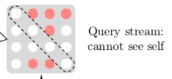
    
이 내용에 대한 코드는 modeling.py에서 찾아볼 수 있었으며 해석은 아래와 같습니다.

  
  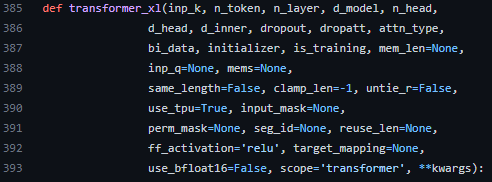

  위 함수의 일부분인 아래 사진에서 그를 확인할 수 있습니다.

  
    
  - 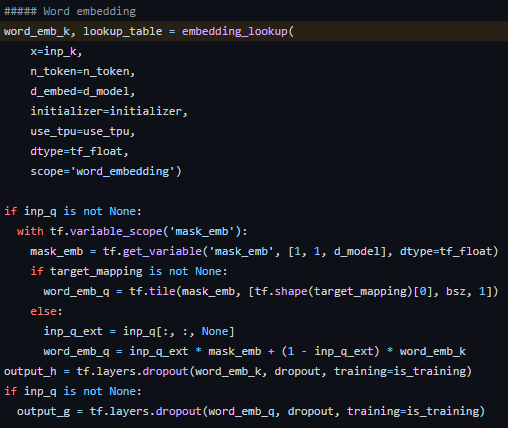

  밑에서 3번째에 있는 output_h가 $h_{z_t}^{(m)}$에 해당하고 가장 마지막 줄에 있는 output_g가 $g_{z_t}^{(m)}$에 해당합니다.


5. Partial Prediction 
  
  permutation을 이용한 language모델은 permutation이 수렴을 느리게 만들기 때문에, 이를 해결하기 위해 XLNet에서는 특정 수 k를 정해 끝에서 부터 k개를 예측합니다. 예측해야 하는 k개의 토큰을 target subsequence라고 하고, 그대로 남겨두는 토큰을 non-target subsequence라고 하는데, non-target sequence를 가지고 maximum likelihood estimation(MLE)를 시행합니다.(여기서도 likelihood에 log를 씌워 시행합니다.
  해당 코드는 data_utils.py에서 찾아볼 수 있습니다

  image.png

  해당 함수에서, 아래 사진과 같은 부분을 보게 되면, 

  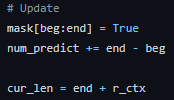

  특정 시작점과 끝점을 정해 해당 영역의 원소를 True로 바꿔주며 마스킹 영역을 지정하는 것을 알 수 있습니다.



      



6. Segment Recurrence Machanism
  Standard transformer의 경우, sequence를 segment단위로 처리할 때, 고정된 positional encoding을 사용합니다. 이 경우, 뒤에있는 segment가 앞에 있는 segment와 같은 위치로 예측되기 때문에, 문제가 생깁니다. 이 문제를 개선해 XLNet에 반영하기 위해 segment Recurrence Mechanism을 사용합니다.

  한 sequence를 2개의 segment로 나누고, 1번째 segment는 m개의 layer를 통과시키며 content representation을 캐싱합니다. 2번째 segment는 $Attention(Q=h_{z_t}^{(m-1)},KV=[content-representation^{(m)}, h_{z<=t}^{(m-1)};Θ ])$로 계산됩니다.
  
  이것에 대한 코드는 modeling.py에서 찾아볼 수 있습니다

  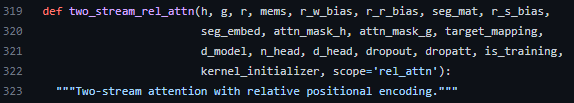

  위 함수에서, 아래의 부분을 보게 되면, 

  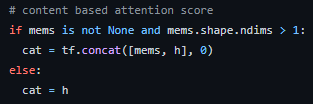

  concat을 하는 부분은 위에 나오고,

  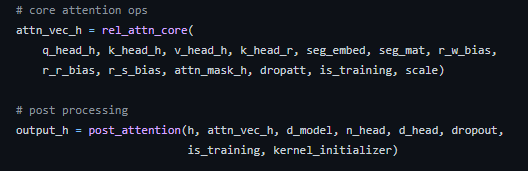

  최종적으로 업데이트 할 결과값을 구하는 것은 위에 나옵니다.




# Fine Tuning

- 기존 모델의 학습 시간이 GPU를 사용함에도 매우 오래걸려 라이브러리를 이용해 재구성했습니다.

- 데이터는 CoLa data set을 사용했고, 이에 대한 적절한 작업을 수행하기 위해, Classification을 수행하는 XLNet을 가져왔습니다.

In [ ]:
! pip install transformers
! pip install pytorch-transformers
from google.colab import files
uploaded = files.upload() # 코랩에서 GUI를 통해 아이콘을 생성하고, 해당 아이콘을 클릭해 파일을 업로드하는 코드드
!unzip cola_public_1.1.zip # cola dataset 압축 풀기

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 15.6 MB/s 
     |████████████████████████████████| 7.6 MB 54.6 MB/s 
     |████████████████████████████████| 182 kB 73.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 176 kB 16.5 MB/s 
     |████████████████████████████████| 132 kB 53.1 MB/s 
     |████████████████████████████████| 1.3 MB 49.4 MB/s 
     |████████████████████████████████| 880 kB 58.6 MB/s 
     |████████████████████████████████| 79 kB 5.8 MB/s 
     |████████████████████████████████| 9.9 MB 33.4 MB/s 
     |████████████████████████████████| 140 kB 61.7 MB/s 
     |████████████████████████████████| 127 kB 57.1 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=7afd703bf63021e4c2840a274b50c9d481951b223a8a897d25dbd2fe69490b2a
  Stor

Saving cola_public_1.1.zip to cola_public_1.1.zip
Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


# 필요한 라이브러리 import

In [ ]:
from transformers import *
import torch
from transformers import XLNetForSequenceClassification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler
import pandas as pd

# 데이터 전처리

In [ ]:
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.head(3)

,sentence_source,label,label_notes,sentence
0,gj04,1,NaN,"Our friends won't buy this analysis, let alone..."
1,gj04,1,NaN,One more pseudo generalization and I'm giving up.
2,gj04,1,NaN,One more pseudo generalization or I'm giving up.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
df=df[['sentence','label']]
df.head(3)

,sentence,label
0,"Our friends won't buy this analysis, let alone...",1
1,One more pseudo generalization and I'm giving up.,1
2,One more pseudo generalization or I'm giving up.,1


In [ ]:
sentences  = []
for sentence in df['sentence']:
  sentence = sentence+"[SEP] [CLS]"
  sentences.append(sentence)

In [ ]:
tokenizer  = XLNetTokenizer.from_pretrained('xlnet-base-cased',do_lower_case=True) #xlnet-base-cased
tokenized_text = [tokenizer.tokenize(sent) for sent in sentences]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/593a21e8b79948a7f952811aa44f37d76e23d586/spiece.model
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None


Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/593a21e8b79948a7f952811aa44f37d76e23d586/config.json
Model config XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 250
    }
  },
  "transformers_version": "4.24.0",
  "untie_r":

In [ ]:
ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_text]

In [ ]:
labels = df['label'].values

In [ ]:
max_ = len(ids[0])
for i in ids:
  max_=max(max_,len(i))
print(max_)
MAX_LEN = max_

54


In [ ]:
input_ids2 = pad_sequences(ids,maxlen=MAX_LEN,dtype="long",truncating="post",padding="post")

In [ ]:
xtrain,xtest,ytrain,ytest = train_test_split(input_ids2,labels,test_size=0.15)

In [ ]:
Xtrain = torch.tensor(xtrain)
Ytrain = torch.tensor(ytrain)
Xtest = torch.tensor(xtest)
Ytest = torch.tensor(ytest)

In [ ]:
batch_size = 256
no_train = 0
epochs = 10

In [ ]:
train_data = TensorDataset(Xtrain,Ytrain)
test_data = TensorDataset(Xtest,Ytest)
loader = DataLoader(train_data,batch_size=batch_size)
test_loader = DataLoader(test_data,batch_size=batch_size)

In [ ]:
def flat_accuracy(preds,labels):  # A function to predict Accuracy
  correct=0
  for i in range(0,len(labels)):
    if(preds[i]==labels[i]):
      correct+=1
  return (correct/len(labels))*100
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased",num_labels=2) # xlnet-base(large)-cased
torch.cuda.empty_cache()
model.cuda()
optimizer = AdamW(model.parameters(),lr=2e-5) # initial learning rate 0.00002

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/593a21e8b79948a7f952811aa44f37d76e23d586/config.json
Model config XLNetConfig {
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 250
    }
  },
  "transformers_version": "4.24.0",
  "untie_r": true,
  "use_mems_eval": true,
  "use_

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--xlnet-base-cased/snapshots/593a21e8b79948a7f952811aa44f37d76e23d586/pytorch_model.bin
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_s

In [ ]:
import torch.nn as nn
criterion = nn.CrossEntropyLoss()

# 모델 학습

- 논문에서는 시그모이드 함수를 loss로 정의했다고 나와있지만, 이를 cross entropy를 사용해보니 CoLa데이터셋에 한하여 더 좋은 성능을 보이는 것을 확인할 수 있습니다. 물론, 시간이 지나며 혹은 라이브러리에 들어간 함수의 코드가 달라졌을 가능성을 감안해야 할 것입니다.

In [ ]:
from tqdm import tqdm
for epoch in range(epochs):
  print("-----------------------------------------------------")
  print("Epoch:",epoch+1)
  model.train()
  loss1 = []
  train_loss = []
  l = []
  for inputs,labels1 in tqdm(loader) :
    inputs.to(device)
    labels1.to(device)
    optimizer.zero_grad()
    outputs = model(inputs.to(device))
    loss = criterion(outputs[0],labels1.to(device)).to(device)
    [train_loss.append(p.item()) for p in torch.argmax(outputs[0],axis=1).flatten() ]#our predicted 
    [l.append(z.item()) for z in labels1]# real labels
    loss.backward()
    optimizer.step()
    loss1.append(loss.item())
    no_train += inputs.size(0)
  print("Loss :",loss.item())
  print("Accuracy :",flat_accuracy(train_loss,l))
  print("-----------------------------------------------------")

-----------------------------------------------------
Epoch: 1


100%|██████████| 29/29 [01:16<00:00,  2.65s/it]


Loss : 0.5930946469306946
Accuracy : 68.49201981287837
-----------------------------------------------------
-----------------------------------------------------
Epoch: 2


100%|██████████| 29/29 [01:18<00:00,  2.70s/it]


Loss : 0.6026481986045837
Accuracy : 70.44578976334618
-----------------------------------------------------
-----------------------------------------------------
Epoch: 3


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


Loss : 0.5856937170028687
Accuracy : 70.58337919647771
-----------------------------------------------------
-----------------------------------------------------
Epoch: 4


100%|██████████| 29/29 [01:23<00:00,  2.87s/it]


Loss : 0.5514096617698669
Accuracy : 71.24380847550908
-----------------------------------------------------
-----------------------------------------------------
Epoch: 5


100%|██████████| 29/29 [01:23<00:00,  2.87s/it]


Loss : 0.41368216276168823
Accuracy : 74.95872317006054
-----------------------------------------------------
-----------------------------------------------------
Epoch: 6


100%|██████████| 29/29 [01:23<00:00,  2.87s/it]


Loss : 0.36521899700164795
Accuracy : 79.21023665382498
-----------------------------------------------------
-----------------------------------------------------
Epoch: 7


100%|██████████| 29/29 [01:23<00:00,  2.87s/it]


Loss : 0.2428840696811676
Accuracy : 82.6086956521739
-----------------------------------------------------
-----------------------------------------------------
Epoch: 8


100%|██████████| 29/29 [01:23<00:00,  2.87s/it]


Loss : 0.18954052031040192
Accuracy : 86.21353880022015
-----------------------------------------------------
-----------------------------------------------------
Epoch: 9


100%|██████████| 29/29 [01:23<00:00,  2.88s/it]


Loss : 0.11090613156557083
Accuracy : 87.75454045129334
-----------------------------------------------------
-----------------------------------------------------
Epoch: 10


100%|██████████| 29/29 [01:23<00:00,  2.87s/it]

Loss : 0.20160402357578278
Accuracy : 89.58447991194276
-----------------------------------------------------
